In [78]:
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import pymc
except ImportError:
    %pip install -q pymc
    
try:
    import corner
except ImportError:
    %pip install -q corner

(PyMC Example)=

# An Introduction into PyMC

This notebook shows an example analysis of an archival data set from VLT/FORS2 using PyMC for inference.

In [79]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
import logging

jax.config.update("jax_enable_x64", True)

logging.getLogger().setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

file_path = luas.__file__
path_to_luas_code = os.path.join(os.path.dirname(file_path)).split(os.sep)
path_to_sample_data = os.sep + os.path.join(*path_to_luas_code[:-2], "docs", "source", "tutorials", "sample_data", "WASP31b_FORS2_600B")

use_binned_data = True

if use_binned_data:
    x_t = np.load(os.path.join(path_to_sample_data, "x_t_binned.npy"))
    Y = np.load(os.path.join(path_to_sample_data, "Y_binned.npy"))
else:
    x_t = np.load(os.path.join(path_to_sample_data, "x_t.npy"))
    Y = np.load(os.path.join(path_to_sample_data, "Y.npy"))

x_l = np.load(os.path.join(path_to_sample_data, "x_l.npy"))
ld_coeff = np.load(os.path.join(path_to_sample_data, "ld_coeff.npy"))
ld_coeff_errs = 0.1 * np.ones_like(ld_coeff)

N_l = x_l.shape[-1]
N_t = x_t.shape[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from luas.kernels import squared_exp
from luas import LuasKernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.power(10, 2*hp["h_CM"])*squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_CM"])) + jnp.diag(jnp.power(10, 2*hp["h_WSS"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return squared_exp(x_t1, x_t2, jnp.power(10, hp["l_t"]))

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.power(10, 2*hp["h_HFS"])*squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_HFS"]))
    if wn:
        Sl += jnp.diag(jnp.power(10, 2*hp["sigma"]))

    return Sl

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(N_t)
St_fn.decomp = "diag"

kernel = LuasKernel(Kl_fn, Kt_fn, Sl_fn, St_fn, use_stored_results = True)

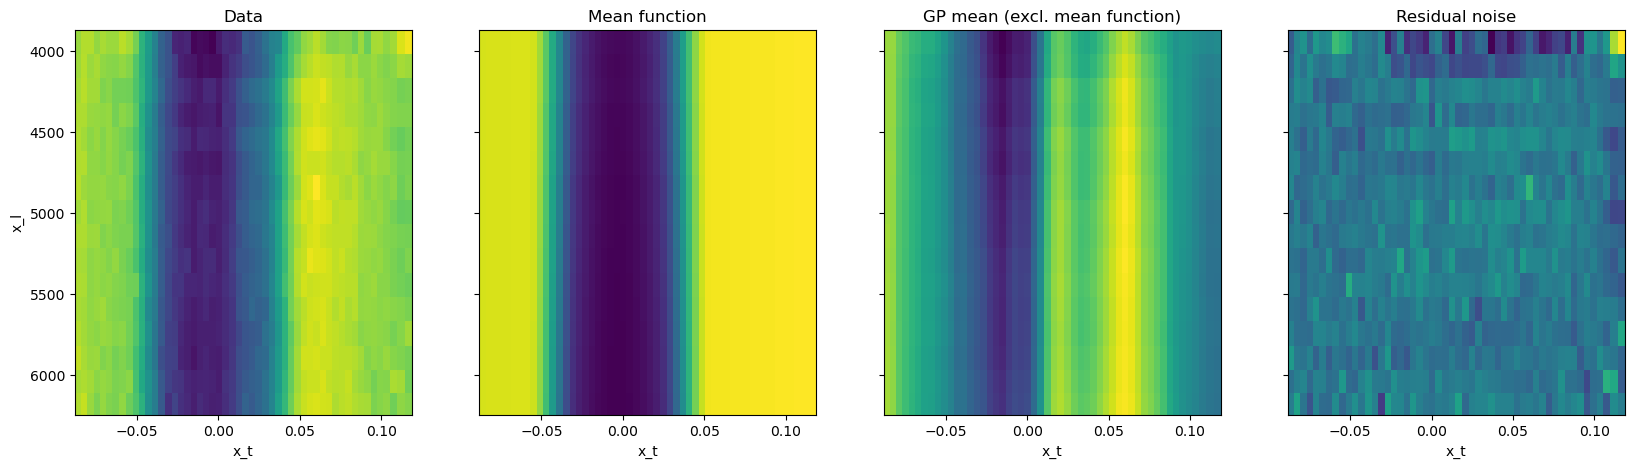

4689.1119641821515


In [81]:
from luas import GP
from luas.exoplanet import transit_2D, ld_from_kipping, ld_to_kipping

u1, u2 = ld_to_kipping(ld_coeff[:N_l, 0], ld_coeff[:N_l, 1])

p_initial = {"T0":-0.0021*np.ones(1), "P":3.4059095*np.ones(1), "a":8.16*np.ones(1), "b":0.771*np.ones(1), "d":0.015*np.ones(N_l), "u1":u1, "u2":u2,
     "Foot":np.ones(N_l)*0.9995, "Tgrad":np.ones(N_l)*0.0002, "h_CM":1.5e-3*np.ones(1), "l_t":0.011*np.ones(1), "l_l_CM":10000.*np.ones(1), "sigma":1.2e-3*np.ones(N_l),
                  "h_WSS":2e-4*np.ones(N_l), "h_HFS":3e-4*np.ones(1), "l_l_HFS":1000.*np.ones(1)}

for par in ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS"]:
    p_initial[par] = np.log10(p_initial[par])

prior_values = {"a":8.19, "b":0.761}
prior_std = {"a":0.1, "b":0.018}

def logPrior(p):
    logPrior = -0.5*((p["a"] - prior_values["a"])/prior_std["a"])**2
    logPrior += -0.5*((p["b"] - prior_values["b"])/prior_std["b"])**2

    c1, c2 = ld_from_kipping(p["u1"], p["u2"])
    logPrior += (-0.5*((c1 - ld_coeff[:N_l, 0])/ld_coeff_errs[:N_l, 0])**2).sum()
    logPrior += (-0.5*((c2 - ld_coeff[:N_l, 1])/ld_coeff_errs[:N_l, 1])**2).sum()

    return logPrior.sum()

gp = GP(kernel, x_l, x_t, mf = transit_2D, logPrior = logPrior)

gp.plot(p_initial, Y)
print(gp.logP(p_initial, Y))

In [90]:
import pymc as pm
from copy import deepcopy
from luas.pymc_ext import LuasPyMC

param_bounds = {"T0":[np.array([-0.01]), np.array([0.01])],
                "d":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "u1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "u2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "sigma":[np.array([-5.]*N_l), np.array([-2.]*N_l)],
                "h_WSS":[np.array([-6.]*N_l), np.array([-2.]*N_l)],
                "h_CM":[np.array([-6.]*1), np.array([-2.]*1)],
                "l_l_CM":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])],
                "h_HFS":[np.array([-6.]), np.array([-2.])],
                "l_l_HFS":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])]}


def transit_model(p_fixed, Y):
    
    with pm.Model() as model:

        var_dict = deepcopy(p_fixed)
        var_dict["T0"] = pm.Uniform('T0',         lower=param_bounds["T0"][0],   upper=param_bounds["T0"][1], shape=1)
        var_dict["d"] = pm.Uniform('d',         lower=param_bounds["d"][0],   upper=param_bounds["d"][1], shape=N_l)
        var_dict["h_CM"] =   pm.Uniform("h_CM", lower=param_bounds["h_CM"][0],      upper=param_bounds["h_CM"][1], shape=1)
        var_dict["l_l_CM"] = pm.Uniform("l_l_CM", lower = param_bounds["l_l_CM"][0], upper = param_bounds["l_l_CM"][1], shape=1)
        var_dict["h_HFS"] =   pm.Uniform("h_HFS", lower=param_bounds["h_HFS"][0],      upper=param_bounds["h_HFS"][1], shape=1)
        var_dict["l_l_HFS"] = pm.Uniform("l_l_HFS", lower = param_bounds["l_l_HFS"][0], upper = param_bounds["l_l_HFS"][1], shape=1)
        var_dict["h_WSS"] =  pm.Uniform('h_WSS',       lower=param_bounds["h_WSS"][0], upper=param_bounds["h_WSS"][1], shape=N_l)
        var_dict["sigma"] = pm.Uniform('sigma',     lower=param_bounds["sigma"][0], upper=param_bounds["sigma"][1], shape=N_l)
        var_dict["u1"] = pm.Uniform('u1',     lower=param_bounds["u1"][0], upper=param_bounds["u1"][1], shape=N_l)
        var_dict["u2"] = pm.Uniform('u2',     lower=param_bounds["u2"][0], upper=param_bounds["u2"][1], shape=N_l)

        var_dict["l_t"] = pm.Flat('l_t', shape=1)
        var_dict["a"] = pm.Flat('a', shape=1)
        var_dict["b"] = pm.Flat('b', shape=1)
        var_dict["Foot"] = pm.Flat('Foot', shape=N_l)
        var_dict["Tgrad"] = pm.Flat('Tgrad', shape=N_l)

        LuasPyMC("log_like", gp = gp, var_dict = var_dict, Y = Y)
        
    return model, var_dict


In [83]:
model, var_dict = transit_model(p_initial, Y)

# PyMC requires the dictionary of starting values to only include variables in the model
# So we must remove the period parameter P as we keep it fixed
p_pymc = deepcopy(p_initial)
del p_pymc["P"]

# Use PyMC's maximum posteriori optimisation method
map_estimate = pm.find_MAP(
    model = model,
    include_transformed = False,
    start = p_pymc,
    maxeval = 30000,
)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt = deepcopy(p_initial)
p_opt.update(map_estimate)

In [84]:
gp.logP(p_opt, Y)

DeviceArray(5398.6616611, dtype=float64)

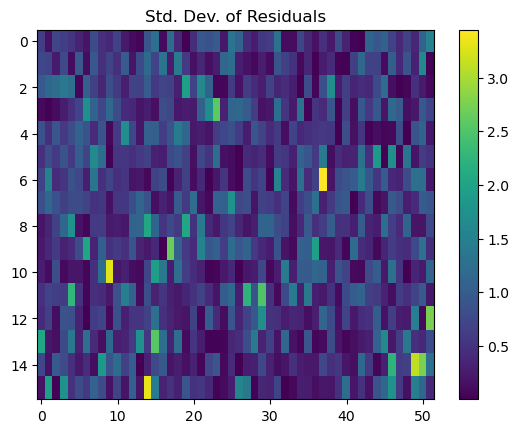

Outliers removed =  0


In [85]:
Y_clean = gp.sigma_clip(p_opt, Y, 4.)

In [86]:
model, var_dict = transit_model(p_opt, Y_clean)
map_estimate2 = pm.find_MAP(model = model, include_transformed = False, start = map_estimate, maxeval = 5000)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt2 = deepcopy(p_initial)
p_opt2.update(map_estimate2)

In [16]:
import pickle

def save_dict(dict_to_save, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

save_dict(p_opt2, os.path.join("sample_data", "p_opt2.pkl"))
np.save(os.path.join("sample_data", "Y_clean.npy"), Y_clean)

In [17]:
import pickle

def load_dict(filename):
    with open(filename, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

p_opt2 = load_dict(os.path.join("sample_data", "p_opt2.pkl"))
Y_clean = np.load(os.path.join("sample_data", "Y_clean.npy"))

In [87]:
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(p_opt2, Y_clean, param_bounds, fixed_vars = ["P"],
                                                            return_array = True, regularise = True, large = False)

Initial number of negative values on diagonal of covariance matrix = 0
Corresponding to parameters: {}.
Remaining number of negative values = 0.


In [92]:
model, var_dict = transit_model(p_opt2, Y_clean)

NUTS_model_vars = [var_dict[par] for par in ordered_param_list]
step1 = pm.NUTS(NUTS_model_vars, scaling = cov_mat, is_cov = True, model = model)

idata = pm.sample(model = model, step = step1, initvals = map_estimate2, draws = 1000,
                          tune = 1000, chains = 2, cores = 1)

INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [Foot, T0, Tgrad, a, b, d, h_CM, h_HFS, h_WSS, l_l_CM, l_l_HFS, l_t, sigma, u1, u2]


/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

KeyboardInterrupt



Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l_t[0],-1.933755,0.041883,-2.005514,-1.859232,0.003506,0.002484,138.515353,131.057915,NaN
a[0],8.224942,0.095898,8.045793,8.390920,0.006304,0.004463,245.100861,149.699169,NaN
b[0],0.767093,0.008572,0.751569,0.782469,0.000648,0.000460,175.580626,94.806295,NaN
u1[0],0.612635,0.156852,0.387148,0.940408,0.008495,0.006220,346.165263,176.755742,NaN
u1[1],0.669332,0.135242,0.413034,0.907492,0.008260,0.005847,257.199179,181.816509,NaN
u1[2],0.670497,0.071344,0.552254,0.819491,0.004389,0.003120,260.488835,149.699169,NaN
u1[3],0.524635,0.063435,0.408397,0.644935,0.004042,0.002861,236.338774,177.700941,NaN
u1[4],0.589702,0.090975,0.443766,0.768988,0.005612,0.003973,247.717796,183.817764,NaN
u1[5],0.636942,0.080369,0.486147,0.778362,0.005225,0.003699,257.863552,170.804653,NaN
u1[6],0.466811,0.064037,0.355986,0.582138,0.004630,0.003279,176.316455,147.633538,NaN


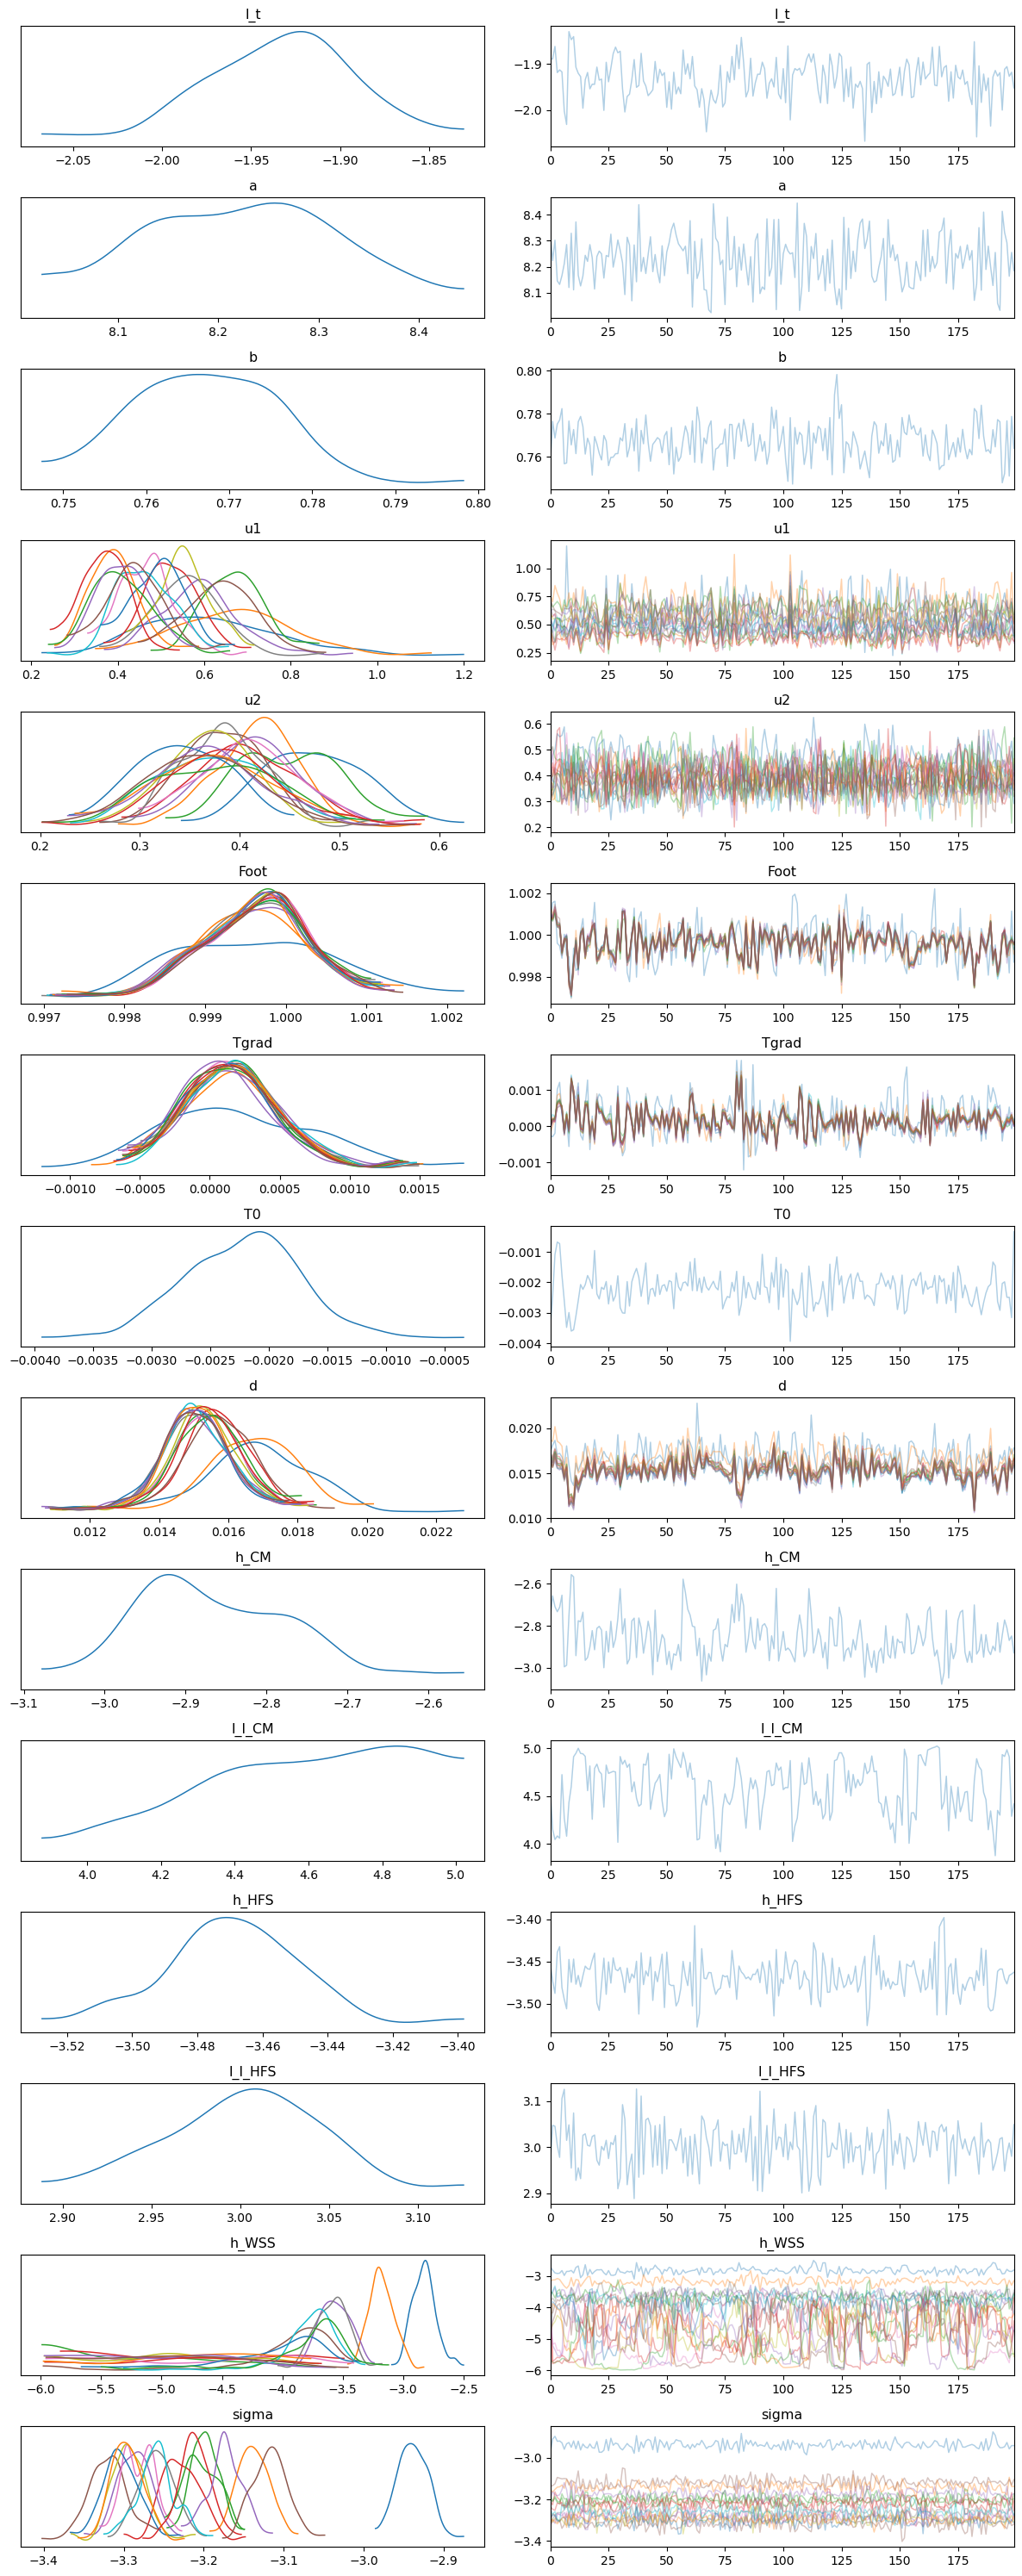

In [22]:
import arviz as az
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print a summary of the samples
df_summary = az.summary(idata, round_to = 6)

trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

df_summary

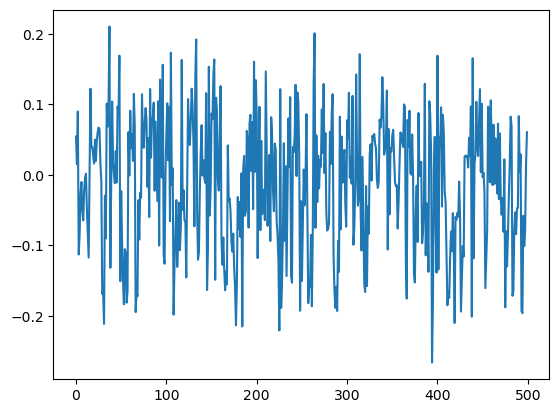

In [79]:
from luas.GPyMCClass import transf_to_pymc, transf_from_pymc

vals = idata.posterior.l_t[0, :, 0].to_numpy()
# plt.plot(idata.posterior.l_t[0, :, 0])

plt.plot(transf_to_pymc(vals, param_bounds["l_t"]))

In [53]:
transf_from_pymc(2.3, param_bounds["l_l_CM"])

DeviceArray([4.72663112], dtype=float64)

In [75]:
p_test = deepcopy(p_opt2)
for l_l_CM_test in jnp.linspace(4.5, 6, 100):
    p_test["l_l_CM"] = l_l_CM_test
    
    l_l_CM_transf = transf_to_pymc(l_l_CM_test, param_bounds["l_l_CM"])
    logPrior_add = jnp.log(1 + jnp.exp(-l_l_CM_transf))
    plt.plot(l_l_CM_transf, logPrior_add + gp.logP(p_test, Y_clean), 'k.')

p_test = deepcopy(p_opt2)  
l_l_CM_test = p_test["l_l_CM"]
l_l_CM_transf = transf_to_pymc(l_l_CM_test, param_bounds["l_l_CM"])
logPrior_add = jnp.log(1 + jnp.exp(-l_l_CM_transf))
# plt.plot(l_l_CM_transf, logPrior_add + gp.logP(p_test, Y_clean), 'r.')
plt.show()

NameError: name 'transf_to_pymc' is not defined

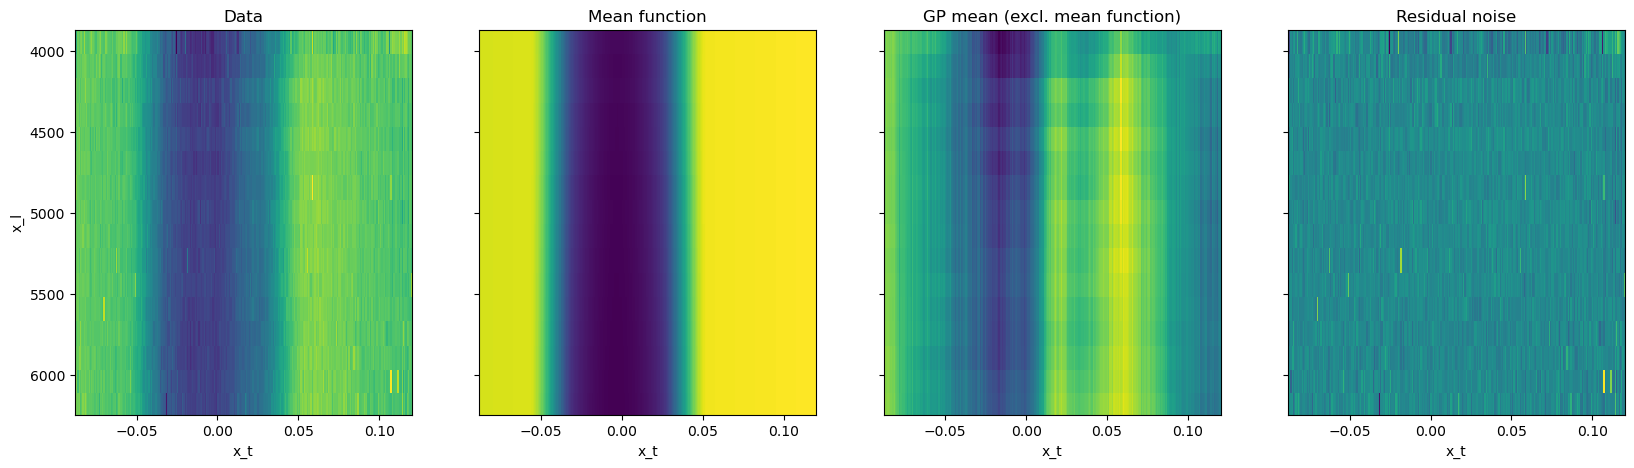

In [6]:
param_bounds = {"T0":[np.ones(1)*-0.004, np.ones(1)*0.],
                "h_WSS":[np.ones(N_l)*-6, np.ones(N_l)*-2],
                "sigma":[np.ones(N_l)*-4, np.ones(N_l)*-2],
                "l_l_CM":[np.ones(1)*2, np.ones(1)*5],
                "d":[np.ones(N_l)*0., np.ones(N_l)*1.],
               }

p_opt = gp.optimise(p, Y, fixed_vars = ["P"], param_bounds = param_bounds)

gp.plot(p, Y)

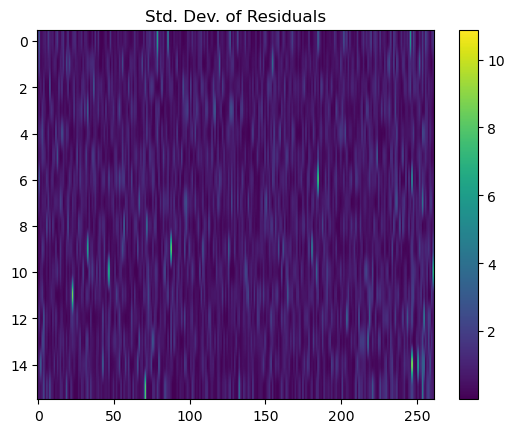

Outliers removed =  17


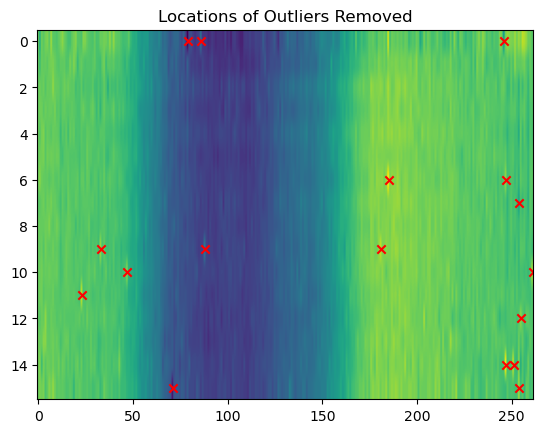

In [9]:
Y_clean = gp.sigma_clip(p_opt, Y, 4.)

In [10]:
p_opt2 = gp.optimise(p_opt, Y_clean, fixed_vars = ["P"], param_bounds = param_bounds)

In [ ]:
["T0", "P", "a", "b", "d", "u1", "u2", "Foot", "Tgrad", "h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS"]

In [ ]:
import pymc as pm

param_bounds = {"T0":[np.ones(1)*-0.004, np.ones(1)*0.],
                "h_WSS":[np.ones(N_l)*-6, np.ones(N_l)*-2],
                "sigma":[np.ones(N_l)*-4, np.ones(N_l)*-2],
                "l_l_CM":[np.ones(1)*2, np.ones(1)*5],
                "d":[np.ones(N_l)*0., np.ones(N_l)*1.],
               }
cov_mat = gp.laplace_approx_for_pymc(p_opt2, Y_clean, param_bounds, fixed_vars = ["P", "l_l_CM"], return_array = True, regularise = True)

idata = gp.mcmc(p_opt2, Y_clean, draws = 500, tune = 500, chains = 1, cores = 1, fixed_vars = ["P"], slice_sample = ["l_l_CM"],
        param_bounds = param_bounds, cov_mat = cov_mat)


Regularised locations where a 0.1 prior sigma was added:  {}


In [34]:
cov_mat = gp.laplace_approx_for_pymc(p_opt2, Y_clean, param_bounds, fixed_vars = ["P"], return_array = False, regularise = True)

model, p_init, par_dict, par_values_ordered = gp.make_default_model(p, Y, fixed_vars = ["P"], param_bounds = param_bounds)

NUTS1_p = ["T0", "a", "b", "d", "u1", "u2", "Foot", "Tgrad", "h_CM", "l_t", "sigma", "h_HFS", "l_l_HFS"]
NUTS1_vars = [par_dict[par] for par in NUTS1_p]
NUTS1_cov = pytree_to_array_2D(cov_mat, select_params = NUTS1_vars)
NUTS_step = pm.NUTS(NUTS1_vars, scaling = NUTS1_cov, is_cov = True, model = model)

idata = pm.sample(model = model, step = NUTS_step, initvals = p_init, draws = 500,
                  tune = 500, chains = 1, cores = 1)

TypeError: Using a non-tuple sequence for multidimensional indexing is not allowed; use `arr[tuple(seq)]` instead of `arr[seq]`. See https://github.com/google/jax/issues/4564 for more information.

In [30]:
par_values_ordered

[Foot ~ Flat(),
 T0 ~ U(-0.004, 0),
 Tgrad ~ Flat(),
 a ~ Flat(),
 b ~ Flat(),
 d ~ U(<constant>, <constant>),
 h_CM ~ Flat(),
 h_HFS ~ Flat(),
 h_WSS ~ U(<constant>, <constant>),
 l_l_CM ~ U(2, 5),
 l_l_HFS ~ Flat(),
 l_t ~ Flat(),
 sigma ~ U(<constant>, <constant>),
 u1 ~ Flat(),
 u2 ~ Flat()]

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Max r_hat:  nan


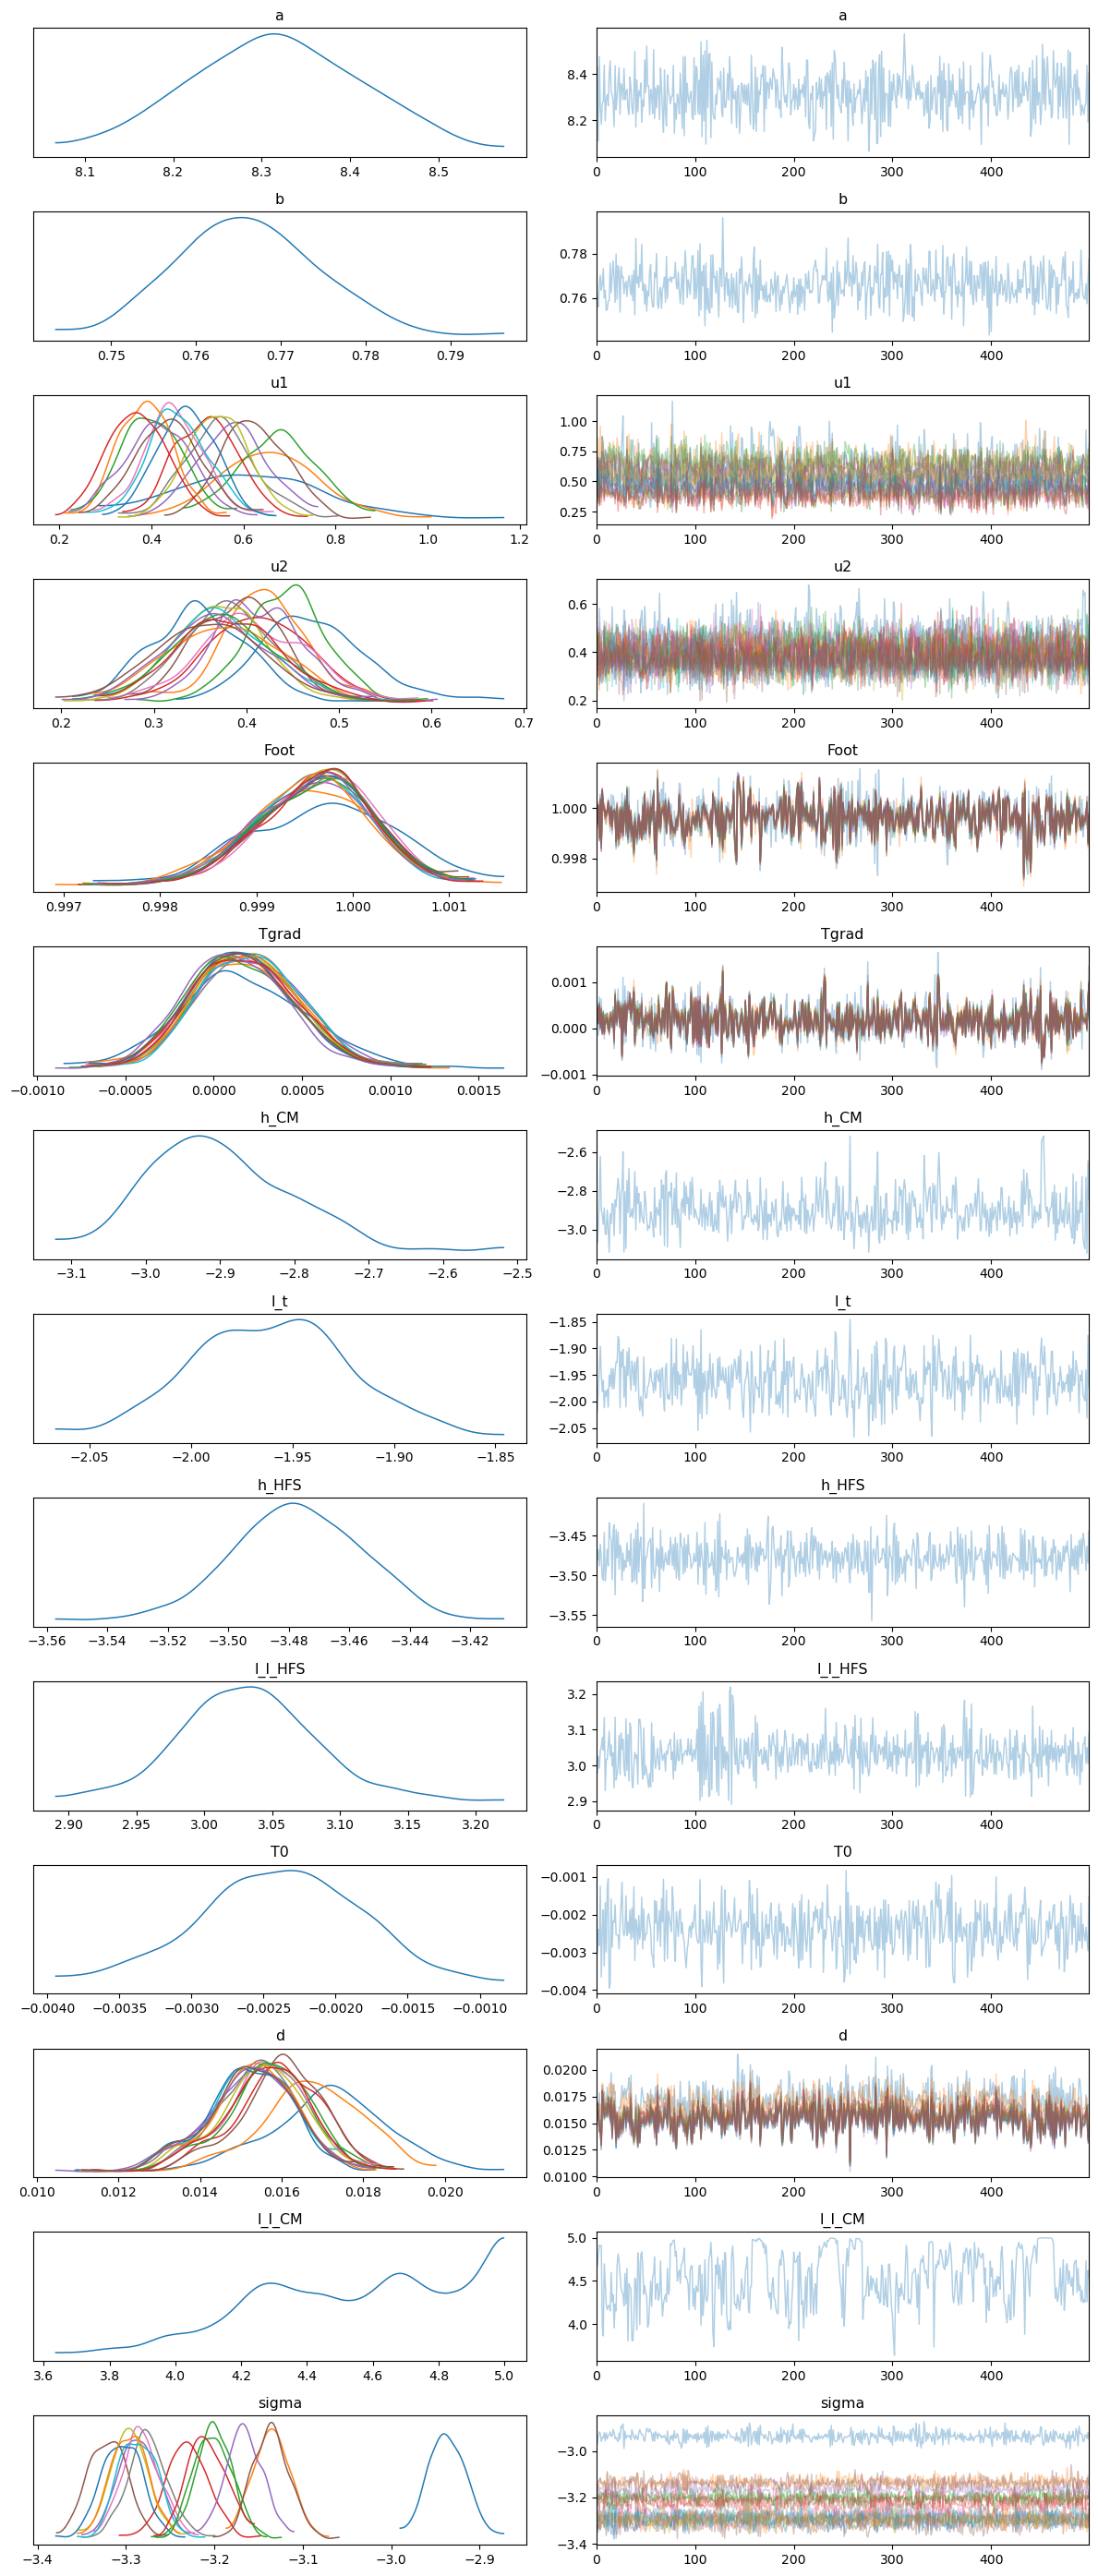

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],8.315266,0.094530,8.151985,8.500832,0.003063,0.002169,951.226954,316.294912,NaN
b[0],0.765981,0.008082,0.752446,0.781702,0.000319,0.000225,658.177837,396.301321,NaN
u1[0],0.613989,0.156691,0.318489,0.900518,0.006254,0.004708,639.751662,366.294141,NaN
u1[1],0.655516,0.106718,0.456054,0.866387,0.004304,0.003374,621.566673,421.859116,NaN
u1[2],0.674452,0.082426,0.507540,0.815498,0.002519,0.001857,1040.175465,266.712612,NaN
u1[3],0.519871,0.068269,0.406413,0.653986,0.002361,0.001711,848.796881,470.239103,NaN
u1[4],0.575567,0.075324,0.448475,0.730090,0.003002,0.002152,624.280792,415.074102,NaN
u1[5],0.623245,0.070252,0.509566,0.769838,0.002650,0.001909,725.413151,392.358232,NaN
u1[6],0.450934,0.068084,0.310321,0.571032,0.002641,0.001928,669.663007,400.787495,NaN
u1[7],0.548857,0.077349,0.415433,0.701180,0.002960,0.002142,677.036056,374.378444,NaN


In [16]:
gp.summary(idata)

In [51]:
p_opt = gp.optimise(p_opt, Y_clean, fixed_vars = ["P"], param_bounds = param_bounds)

In [55]:
gp.logL(p_opt, Y_clean), gp.logL(p, Y_clean)

(Array(24676.14492275, dtype=float64), Array(23343.37089876, dtype=float64))

In [44]:
import pymc as pm
from luas.pymc_convenience_fns import order_dict, AesaraWrapperValueGrad

p_arr, make_p_fit_dict = ravel_pytree(p)

def make_p(p_arr):
    p_fit = make_p_fit_dict(p_arr)
    p_fixed = deepcopy(p)
    p_fixed.update(p_fit)
    return p_fixed

logP_stored = lambda p_arr, storage_dict: gp.logP_stored(make_p(p_arr), Y, storage_dict)
logP_pymc = AesaraWrapperValueGrad(logP_stored)

In [54]:
p_fit = deepcopy(p)
param_bounds = {}

par_dict = {}
        
with pm.Model() as model:
    for par in p_fit.keys():
        if par in param_bounds.keys():
            par_dict[par] = pm.Uniform(par, lower=param_bounds[par][0],
                                                        upper=param_bounds[par][1], shape=p_fit[par].size)
        else:
            par_dict[par] = pm.Flat(par, shape=p_fit[par].size)

par_list = order_dict(par_dict)
p_pymc = pm.math.concatenate(par_list)
loglike = pm.Potential("gp_loglike", logP_pymc(p_pymc), model = model)

In [56]:
map_estimate = pm.find_MAP(model = model, start = p_fit, vars = par_list)

NotImplementedError: Cannot convert Array([0.], dtype=float64) to a tensor variable.

In [46]:
logP_pymc(np.array(p_arr)).eval()

array(19126.80733298)

In [6]:
storage_dict = gp.calc_storage_dict(p)

In [7]:
gp.logL(p, Y), gen_gp.logL(p, Y)

(Array(19133.01227714, dtype=float64), Array(19133.01227714, dtype=float64))

In [8]:
grad_logL_kron = ravel_pytree(jax.grad(gp.logL)(p, Y))[0]
grad_logL_exact = ravel_pytree(jax.grad(gen_gp.logL)(p, Y))[0]

grad_logL_kron - grad_logL_exact

Array([ 1.68256520e-11,  1.40971679e-11, -8.27640179e-11,  9.36779543e-11,
       -1.59161573e-11, -4.50199877e-11,  5.22959454e-11, -3.77440301e-11,
       -5.68434189e-11,  7.32143235e-11,  5.09317033e-11, -5.77529136e-11,
       -4.54747351e-13, -9.54969437e-12,  2.93312041e-11,  1.40971679e-11,
       -5.00222086e-12, -2.18278728e-11, -3.81987775e-11,  1.81898940e-12,
       -3.13775672e-11,  4.50199877e-11, -3.41060513e-11, -1.63709046e-11,
        1.54614099e-11, -4.91127139e-11, -5.09317033e-11,  1.63709046e-11,
       -1.81898940e-12, -2.72848411e-11, -1.63709046e-11,  7.27595761e-12,
        1.04591891e-11, -2.45563569e-11, -6.82121026e-13, -2.72848411e-12,
       -2.18278728e-11,  7.27595761e-12,  5.63886715e-11, -3.27418093e-11,
        3.63797881e-12,  3.63797881e-11, -3.81987775e-11,  9.09494702e-12,
        1.63709046e-11, -2.18278728e-11, -8.18545232e-12,  3.27418093e-11,
       -5.45696821e-12,  1.09139364e-11, -7.27595761e-12, -1.09139364e-11,
        2.79396772e-09,  

In [14]:
p

{'T0': Array([0.], dtype=float64),
 'P': Array([4.], dtype=float64),
 'a': Array([8.], dtype=float64),
 'd': Array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01], dtype=float64),
 'b': Array([0.8], dtype=float64),
 'u1': Array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5], dtype=float64),
 'u2': Array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2], dtype=float64),
 'Foot': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float64),
 'Tgrad': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64),
 'h_CM': Array([0.001], dtype=float64),
 'l_l_CM': Array([1000.], dtype=float64),
 'h_WSS': Array([0.0001], dtype=float64),
 'h_HFS': Array([0.0001], dtype=float64),
 'l_l_HFS': Array([500.], dtype=float64),
 'sigma': Array([0.003], dtype=float64),
 'l_t': Array([0.1], dtype=float64)}

In [13]:
p_arr, make_p_dict = ravel_pytree(p_2D)
logP_arr = lambda p_arr: gp_2D.logP(make_p_dict(p_arr), Y)

H1 = jax.hessian(logP_arr)(p_arr)[0]
H12 = gp.hessian_logP(p, Y, return_array = True)
H2 = gen_gp_2D.hessian_logP(p, Y, return_array = True)

(H1 - H2).std(), (H12 - H2).std()

(Array(1276125.55446365, dtype=float64), Array(2.5569067e-09, dtype=float64))

In [17]:
gp.laplace_approx(p, Y, return_array = True, select_params = ["d"])

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function hessian_logP at /Users/mark/Code/luas/src/luas/GPClass.py:181 for jit. 
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [10]:
H1[:5, :5]

Array([[-1.29954869e+06,  0.00000000e+00,  0.00000000e+00,
         3.41147775e-01,  0.00000000e+00],
       [ 0.00000000e+00, -1.62632011e+07,  0.00000000e+00,
         0.00000000e+00,  7.21867514e-03],
       [ 0.00000000e+00,  0.00000000e+00, -7.86131869e+06,
         0.00000000e+00,  0.00000000e+00],
       [ 3.41147775e-01,  0.00000000e+00,  0.00000000e+00,
        -5.01405247e-07,  0.00000000e+00],
       [ 0.00000000e+00,  7.21867514e-03,  0.00000000e+00,
         0.00000000e+00, -1.99127071e-09]], dtype=float64)

In [9]:
p_arr, make_p_dict = ravel_pytree(p_2D)
logL_arr = lambda p_arr: gp_2D.logL(make_p_dict(p_arr), Y)

H1 = jax.hessian(logL_arr)(p_arr)
H2 = gen_gp_2D.hessian_logL(p_2D, Y, return_array = True)

(H1 - H2).std()

run


Array(1266628.41753925, dtype=float64)

In [10]:
H1[:5, :5]

Array([[-1.29954869e+06,  0.00000000e+00,  0.00000000e+00,
         3.41147775e-01,  0.00000000e+00],
       [ 0.00000000e+00, -1.62632011e+07,  0.00000000e+00,
         0.00000000e+00,  7.21867514e-03],
       [ 0.00000000e+00,  0.00000000e+00, -7.86131869e+06,
         0.00000000e+00,  0.00000000e+00],
       [ 3.41147775e-01,  0.00000000e+00,  0.00000000e+00,
        -5.01405247e-07,  0.00000000e+00],
       [ 0.00000000e+00,  7.21867514e-03,  0.00000000e+00,
         0.00000000e+00, -1.99127071e-09]], dtype=float64)

In [40]:
H12 = gp_2D.hessian_logL(p_2D, Y, return_array = True)

(H1 - H2).std()

ran


NameError: name 'W_Kl_W' is not defined

In [104]:
(H1 - H2).std()

Array(2.5579063e-09, dtype=float64)

In [31]:
(H1 - H2)[:3, :3], (H12 - H2)[:3, :3]

(Array([[-1.88530693e+06, -1.28909936e+04, -2.44974532e+05],
        [-1.28909936e+04, -9.61884314e+04, -1.84111249e+03],
        [-2.44974532e+05, -1.84111249e+03, -5.39279641e+05]],      dtype=float64),
 Array([[ 5.58793545e-09,  3.93811206e-10, -8.09086487e-09],
        [ 5.45696821e-12, -1.86264515e-09, -8.64019967e-12],
        [-3.66708264e-09, -1.36424205e-11,  1.60653144e-08]],      dtype=float64))

In [59]:
additional_term_wrapper = lambda p_arr1, p_arr2: gp_2D.kf.additional_hessian_term(make_p_dict(p_arr1),
                                                                                  make_p_dict(p_arr2),
                                                                                  x_l, x_t, storage_dict)
hess_part2 = jax.jacfwd(jax.jacrev(additional_term_wrapper, argnums = 1), argnums = 0)(p_arr, p_arr)
0.5*hess_part2[:5, :5]

Array([[-1.88530693e+06, -1.28909936e+04, -2.44974532e+05,
         4.10899196e-02, -3.90949169e-05],
       [-1.28909936e+04, -9.61884314e+04, -1.84111249e+03,
         3.54537273e-04, -9.91648824e-04],
       [-2.44974532e+05, -1.84111249e+03, -5.39279641e+05,
         1.53706813e-01,  2.24980729e-04],
       [ 4.10899196e-02,  3.54537273e-04,  1.53706813e-01,
        -6.83198376e-08, -1.00532504e-10],
       [-3.90949169e-05, -9.91648824e-04,  2.24980729e-04,
        -1.00532504e-10, -2.54255567e-11]], dtype=float64)

In [ ]:
%timeit gp.logL(p_1D, Y_1D).block_until_ready()
%timeit gen_gp.logL(p_1D, Y_1D).block_until_ready()

%timeit gp_2D.logL(p_2D, Y).block_until_ready()
%timeit gen_gp_2D.logL(p_2D, Y).block_until_ready()

In [ ]:
H_arr = gp_2D.hessian_logP(p_2D, Y, return_array = True)
H_dict = gp_2D.hessian_logP(p_2D, Y, return_array = False)

In [ ]:
plt.imshow(H_dict["mfp"]["d"]["mfp"]["d"])

In [ ]:
H_arr = gp_2D.laplace_approx(p_2D, Y, return_array = False)
plt.imshow(H_arr["mfp"]["d"]["mfp"]["d"])

In [ ]:
H_arr = gp_2D.laplace_approx(p_2D, Y, return_array = True, select_params = ["d", "u1"])
plt.imshow(H_arr)

In [ ]:
gp_mean, sigma_diag, M = gp_2D.predict(p_2D, Y)
gp_mean2, sigma_diag2, M2 = gen_gp_2D.predict(p_2D, Y)

print((M - M2).std())

In [ ]:
gp_2D.plot(p_2D, Y)
gen_gp_2D.plot(p_2D, Y)

In [ ]:
gp.logL(p_1D, Y_1D)
# gp.logL(p_2D, Y_1D)
# gp.logL(p_1D, Y)
# gp.logL(p_2D, Y)
gp_2D.logL(p_2D, Y)
gp_2D.logL(p_1D, Y)
gp_2D.logL(p_2D, Y_1D)
# gp_2D.logL(p_1D, Y_1D)

In [ ]:
Y_1D = Y_1D.reshape((1, Y_1D.size))

In [ ]:
# gp.plot(p_1D, Y_1D)
# gp.logL(p_2D, Y_1D)
# gp.logL(p_1D, Y)
# gp.logL(p_2D, Y)
gp_2D.plot(p_2D, Y)
# gp_2D.plot(p_1D, Y)
# gp_2D.plot(p_2D, Y_1D)

In [ ]:
np.subtract(Y, gp_2D.mf(p_1D["mfp"], x_l, x_t)[0, :])
Y.shape, gp_2D.mf(p_1D["mfp"], x_l, x_t)[0, :].shape

In [ ]:
gp_2D.mf(p["mfp"], x_l, x_t).shape

In [ ]:
%timeit gp.logL(p, Y).block_until_ready()
%timeit gen_gp.logL(p, Y).block_until_ready()

In [ ]:
gp.logL(p, Y[:1, :])

In [ ]:
storage_dict = gp.calc_storage_dict(p)

In [ ]:
x_l_pred = jnp.interp(jnp.linspace(0, 1, 300), jnp.linspace(0, 1, N_l), x_l)
x_t_pred = jnp.interp(jnp.linspace(0, 1, 1000), jnp.linspace(0, 1, N_t), x_t)
gp_mean, sigma_diag, M = gp.predict(p, Y, x_l_pred = x_l_pred, x_t_pred = x_t_pred)

plt.imshow(gp_mean - M, aspect = 'auto')
plt.show()
plt.imshow(Y, aspect = 'auto')

In [ ]:
ravel_pytree(jax.grad(gp.logP)(p, Y))[0]-ravel_pytree(jax.grad(gen_gp.logP)(p, Y))[0]

In [9]:
jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)

%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)

427 ms ± 9.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
147 ms ± 756 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [87]:
from copy import deepcopy

gp.logL(p, Y)
gp.logL_stored(p, Y, {})
gp.logL_stored(p, Y, storage_dict);
jax.grad(gp.logL)(p, Y)
jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
jax.value_and_grad(gp.logL)(p, Y)
jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, {})
jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
jax.hessian(gp.logL)(p, Y)
jax.hessian(gp.logL_stored, has_aux = True)(p, Y, {})
jax.hessian(gp.logL_stored, has_aux = True)(p, Y, storage_dict)

%timeit gp.logL(p, Y)
%timeit gp.logL_stored(p, Y, {})
%timeit gp.logL_stored(p, Y, storage_dict);
%timeit jax.grad(gp.logL)(p, Y)
%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
%timeit jax.value_and_grad(gp.logL)(p, Y)
%timeit jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
%timeit jax.hessian(gp.logL)(p, Y)
%timeit jax.hessian(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.hessian(gp.logL_stored, has_aux = True)(p, Y, storage_dict)

34.4 ms ± 5.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.3 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
734 µs ± 8.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.1 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.5 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.8 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
46.5 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.6 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.3 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
998 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.3 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
921 ms ± 55.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
from copy import deepcopy

gp.logL(p, Y)
gp.logL_stored(p, Y, {})
gp.logL_stored(p, Y, storage_dict);
jax.grad(gp.logL)(p, Y)
jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
jax.value_and_grad(gp.logL)(p, Y)
jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, {})
jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
gp.hessian_logL(p, Y)

%timeit gp.logL(p, Y)
%timeit gp.logL_stored(p, Y, {})
%timeit gp.logL_stored(p, Y, storage_dict);
%timeit jax.grad(gp.logL)(p, Y)
%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
%timeit jax.value_and_grad(gp.logL)(p, Y)
%timeit jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, {})
%timeit jax.value_and_grad(gp.logL_stored, has_aux = True)(p, Y, storage_dict)
%timeit gp.hessian_logL(p, Y)

33.7 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.6 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
763 µs ± 6.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
44.4 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
46.9 ms ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.3 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.7 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.34 s ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
logL_jit = jax.jit(gp.logL)
grad_logL_jit = jax.jit(jax.grad(gp.logL))
grad_logL_aux_jit = jax.jit(jax.grad(gp.logL, has_aux = True))
value_grad_logL_jit = jax.jit(jax.value_and_grad(gp.logL))
value_grad_logL_aux_jit = jax.jit(jax.value_and_grad(gp.logL, has_aux = True))

logL_jit(p, Y)
logL_jit(p, Y, storage_dict = {})
logL_jit(p, Y, storage_dict = storage_dict);
grad_logL_jit(p, Y)
grad_logL_aux_jit(p, Y, storage_dict = {})
grad_logL_aux_jit(p, Y, storage_dict = storage_dict)
value_grad_logL_jit(p, Y)
value_grad_logL_aux_jit(p, Y, storage_dict = {})
value_grad_logL_aux_jit(p, Y, storage_dict = storage_dict)


%timeit logL_jit(p, Y)
%timeit logL_jit(p, Y, storage_dict = {})
%timeit logL_jit(p, Y, storage_dict = storage_dict);
%timeit grad_logL_jit(p, Y)
%timeit grad_logL_aux_jit(p, Y, storage_dict = {})
%timeit grad_logL_aux_jit(p, Y, storage_dict = storage_dict)
%timeit value_grad_logL_jit(p, Y)
%timeit value_grad_logL_aux_jit(p, Y, storage_dict = {})
%timeit value_grad_logL_aux_jit(p, Y, storage_dict = storage_dict)